In [688]:
import numpy as np
import xarray as xr
import matplotlib.pyplot as plt

<xarray.Dataset>
Dimensions:  (lat: 120, lon: 450)
Coordinates:
  * lon      (lon) float64 -18.99 -18.97 -18.96 -18.94 ... -11.54 -11.53 -11.51
  * lat      (lat) float64 -21.99 -21.98 -21.96 -21.94 ... -20.04 -20.02 -20.01
    X        (lon) float64 0.0 1.727e+03 3.454e+03 ... 7.736e+05 7.753e+05
    Y        (lat) float64 0.0 1.853e+03 3.706e+03 ... 2.187e+05 2.205e+05
Data variables:
    z        (lat, lon) float32 ...
Attributes:
    Conventions:  COARDS, CF-1.5
    title:        
    history:      grdsample -R-180/180/-80/80 -I1m @GMTAPI@-000001 -Gtopo_19....
    description:  
    GMT_version:  5.4.5 [64-bit]
    node_offset:  1

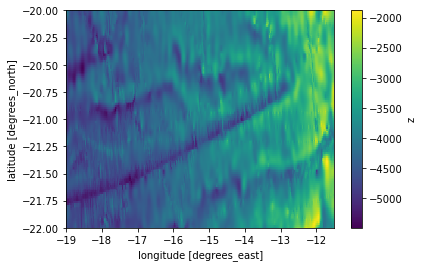

In [689]:
ds = xr.open_dataset("../../data/SS97_topography.nc")
ds = ds.sel(lon=slice(-19,-11.5), lat=slice(-22.,-20.))

R = 6.371e6
circ = 2.*np.pi*R

ds = ds.assign_coords({
    'X': (ds['lon'] - ds['lon'].isel(lon=0)) * circ/360. * np.cos(np.deg2rad(ds['lat'].sel(lat=-21.3, method='nearest'))),
    'Y': (ds['lat'] - ds['lat'].isel(lat=0)) * circ/360.
})
ds['z'].plot()

ds

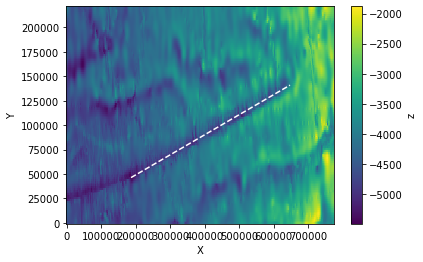

In [690]:
lats_deg = [-21.575, -20.725]; lons_deg = [-17.2, -12.75]
lats_dist = ds['Y'].sel(lat=lats_deg, method='nearest')
lons_dist = ds['X'].sel(lon=lons_deg, method='nearest')

ds['z'].plot(x='X', y='Y')
plt.plot(lons_dist, lats_dist, 'w--')

In [691]:
canyon_angle = np.arctan(np.diff(lats_dist)/np.diff(lons_dist))

In [692]:
Lx = 4e5
nx = 1000

Ly = 6e4
ny = 120

Xr_1d = np.arange(0., Lx, Lx/nx)[np.newaxis,:]
Yr_1d = np.arange(0., Ly, Ly/ny)[:,np.newaxis]

In [693]:
X = xr.DataArray(
    data = Xr_1d*np.cos(canyon_angle) - Yr_1d*np.sin(canyon_angle),
    coords = {'Yr': Yr_1d.flatten(), 'Xr': Xr_1d.flatten()},
    dims = ['Yr', 'Xr']
)
Y = xr.DataArray(
    data = Yr_1d*np.cos(canyon_angle) + Xr_1d*np.sin(canyon_angle),
    coords = {'Yr': Yr_1d.flatten(), 'Xr': Xr_1d.flatten()},
    dims = ['Yr', 'Xr']
)

<xarray.Dataset>
Dimensions:  (Xr: 1000, Yr: 120)
Coordinates:
    lon      (Yr, Xr) float64 -17.19 -17.19 -17.18 ... -13.54 -13.53 -13.53
    lat      (Yr, Xr) float64 -21.84 -21.84 -21.84 -21.84 ... -20.6 -20.6 -20.6
    X        float64 1.865e+05
    Y        float64 4.633e+04
  * Yr       (Yr) float64 0.0 500.0 1e+03 1.5e+03 ... 5.85e+04 5.9e+04 5.95e+04
  * Xr       (Xr) float64 0.0 400.0 800.0 ... 3.988e+05 3.992e+05 3.996e+05
Data variables:
    z        (Yr, Xr) float64 -4.5e+03 -4.504e+03 ... -3.149e+03 -3.159e+03

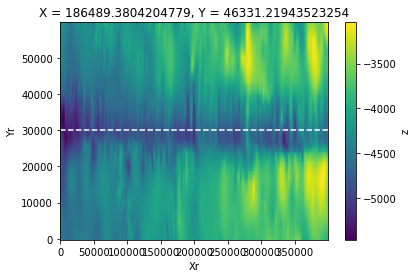

In [694]:
newds = xr.Dataset()
newds['z'] = (
    ds['z']
    .swap_dims({'lon':'X', 'lat':'Y'})
    .interp(X=X+lons_dist[0], Y=Y+lats_dist[0]-Ly/2)
)

newds['z'].plot()
plt.plot(newds['Xr'], 0.*newds['Xr'] + Ly/2, "w--")
newds

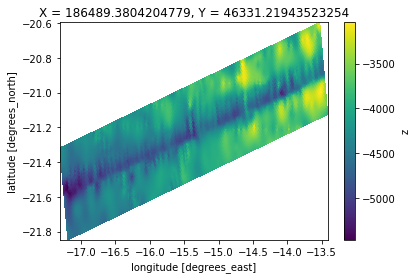

In [695]:
newds['z'].plot(x='lon', y='lat')

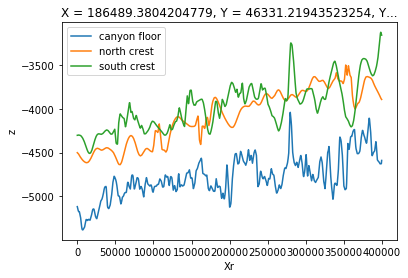

In [696]:
newds['z'].sel(Yr=3e4, method='nearest').plot(label='canyon floor')
newds['z'].isel(Yr=0).plot(label='north crest')
newds['z'].isel(Yr=-1).plot(label='south crest')
plt.legend()

In [697]:
a, b = np.polyfit(newds['Xr'], newds['z'].sel(Yr=3e4, method='nearest'), deg=1)
newds['z_slope'] = a*newds['Xr'] + b

newds['z_with_slope'] = newds['z'].copy()
newds['z'] = newds['z'] - newds['z_slope']

nx_smooth = 7
for i in range(nx_smooth):
    newds['z'].loc[{'Xr': newds['Xr'].isel(Xr=-nx_smooth//2+i)}] = (
        newds['z'].loc[{'Xr': newds['Xr'].isel(Xr=-nx_smooth//2)}] +
        i/nx_smooth*(
            newds['z'].loc[{'Xr': newds['Xr'].isel(Xr=-nx_smooth//2+nx_smooth)}] -
            newds['z'].loc[{'Xr': newds['Xr'].isel(Xr=-nx_smooth//2)}]
        )
    )
    
ny_smooth = 11
for j in range(ny_smooth):
    newds['z'].loc[{'Yr': newds['Yr'].isel(Yr=-ny_smooth//2+j)}] = (
        newds['z'].loc[{'Yr': newds['Yr'].isel(Yr=-ny_smooth//2)}] +
        j/ny_smooth*(
            newds['z'].loc[{'Yr': newds['Yr'].isel(Yr=-ny_smooth//2+ny_smooth)}] -
            newds['z'].loc[{'Yr': newds['Yr'].isel(Yr=-ny_smooth//2)}]
        )
    )

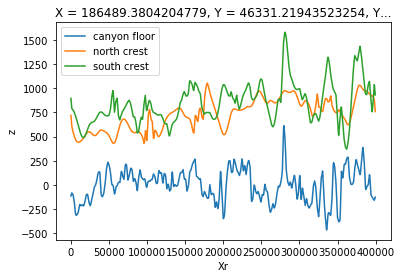

In [707]:

newds['z'].sel(Yr=3e4, method='nearest').plot(label='canyon floor')
newds['z'].isel(Yr=10).plot(label='north crest')
newds['z'].isel(Yr=-10).plot(label='south crest')
plt.legend()

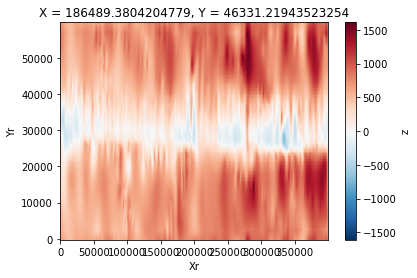

In [702]:
q = newds['z'].plot()

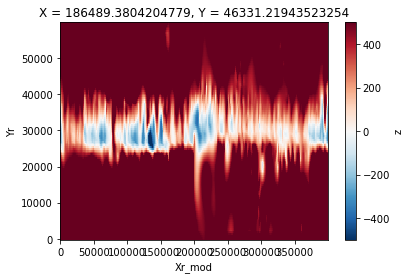

In [700]:
newds = newds.assign_coords({'Xr_mod': np.mod(newds['Xr']+Lx/2, Lx)})
q = newds['z'].sortby(newds['Xr_mod']).plot(x='Xr_mod', y='Yr')
q.set_clim([-500,500])

In [968]:
def pre_process(ds):
    DEPTH = xr.DataArray(
        data = np.arange(0., 6000., 0.5),
        coords = {'DEPTH': np.arange(0., 6000., 0.5)},
        dims = ['DEPTH']
    )
    ds = ds.isel(DEPTH=~np.isnan(ds['DEPTH'])).interp(DEPTH=DEPTH).drop('CHI-T')
    for coord in ds.coords.keys():
        if coord not in ['TIME', 'DEPTH']:
            ds[coord] = ds[coord] + 1.e-5*np.random.rand()
            
    ds = ds.assign_coords({
        'CAST_NUM': xr.DataArray(
            np.array([np.int64(ds.attrs['cast_number'])]),
            dims = 'CAST_NUM'
        )
    })
    for coord in ds.coords.keys():
        if coord not in ['CAST_NUM', 'DEPTH']:
            ds.coords[coord] = ds[coord].assign_coords(
                {'CAST_NUM': xr.DataArray(ds['CAST_NUM'].data, dims=[coord])}
            )
            ds[coord] = ds[coord].swap_dims({coord: 'CAST_NUM'})
    return ds

bbtre = xr.open_mfdataset(
    "../../data/bbtre97_microstructure/bbtre97_*.nc",
    combine='nested',
    concat_dim=['CAST_NUM'],
    preprocess=pre_process)

bbtre

<xarray.Dataset>
Dimensions:      (CAST_NUM: 80, DEPTH: 12000)
Coordinates:
  * DEPTH        (DEPTH) float64 0.0 0.5 1.0 1.5 ... 5.998e+03 5.999e+03 6e+03
    LATITUDE     (CAST_NUM) float64 -13.31 -21.73 -21.67 ... -20.97 -21.77
    LONGITUDE    (CAST_NUM) float64 -30.38 -18.56 -18.18 ... -20.51 -19.41
    TIME         (CAST_NUM) datetime64[ns] 1997-03-15T16:10:59.999997440 ... 1997-03-21T09:42:59.999997184
    BOT_DEPTH    (CAST_NUM) float64 -99.0 5.298e+03 ... 4.692e+03 5.328e+03
  * CAST_NUM     (CAST_NUM) int64 1 12 13 14 15 16 17 18 ... 84 85 86 87 88 89 9
Data variables:
    EPSILON      (CAST_NUM, DEPTH) float64 dask.array<chunksize=(1, 12000), meta=np.ndarray>
    PRESSURE     (CAST_NUM, DEPTH) float64 dask.array<chunksize=(1, 12000), meta=np.ndarray>
    PSAL         (CAST_NUM, DEPTH) float64 dask.array<chunksize=(1, 12000), meta=np.ndarray>
    TEMPERATURE  (CAST_NUM, DEPTH) float64 dask.array<chunksize=(1, 12000), meta=np.ndarray>
Attributes:
    Conventions:           CF-1.6
    netcdf_version:        4
    project:               BBTRE 97
    expocode:              33SW19970313
    cast_number:           1.0
    title:                 Microstructure profiler data from the ship Seward ...
    time:                  Mar-15-1997
    latitude:              -13.309166666666666
    longitude:             -30.3815
    chief_scientist:       James R. Ledwell
    data_originator:       Polzin/St. Laurent/Toole
    institution:           WHOI
    data_assembly_center:  CCHDO